In [1]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

In [13]:
import os
import pandas as pd
import numpy as np

In [3]:
reductions = os.listdir('../data/som_reductions')

In [4]:
reductions

['SCALED_reduction_100_10000_epochs.csv',
 'reduction_2_1_epochs.csv',
 'reduction_50_10000_epochs.csv',
 'reduction_3_1_epochs.csv',
 'reduction_25_10000_epochs.csv',
 'SCALED_reduction_5_5_epochs.csv',
 'reduction_100_10000_epochs.csv',
 'SCALED_reduction_35_10000_epochs.csv',
 'reduction_35_10000_epochs.csv',
 'SCALED_reduction_50_10000_epochs.csv',
 'SCALED_reduction_25_10000_epochs.csv']

In [9]:
df = pd.read_csv('../data/som_reductions/reduction_100_10000_epochs.csv', index_col=0)

In [10]:
df

,x,y,Appliances
0,16.5,63.219854,60
1,19.5,61.487804,60
2,26.0,57.157677,50
3,35.0,53.693575,50
4,18.0,79.674337,60
...,...,...,...
19730,74.0,29.444864,100
19731,73.0,29.444864,90
19732,79.5,26.846788,270
19733,87.5,21.650635,420


In [14]:
max_lags = 12
test ='ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=max_lags, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(max_lags)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [15]:
grangers_causation_matrix(df, variables = df.columns)        

/home/matheus_cascalho/.virtualenvs/Appliance-Energy-Prediction/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,x_x,y_x,Appliances_x
x_y,1.0000,0.0000,0.0012
y_y,0.0000,1.0000,0.0022
Appliances_y,0.0002,0.0438,1.0000


In [17]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
x      ::  1331.17   > 24.2761   =>   True
y      ::  239.38    > 12.3212   =>   True
Appliances ::  45.79     > 4.1296    =>   True


In [20]:
nobs = 4
df_train, df_test = df[:14801], df[14801:]

print(df_train.shape)
print(df_test.shape)

(14801, 3)
(4934, 3)


In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [22]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "x" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4806
 No. Lags Chosen       = 32
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1053
 No. Lags Chosen       = 29
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [24]:
model = VAR(df)
aics = []
for i in range(17):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    aics.append(result.aic)

Lag Order = 0
AIC :  22.191991356320727
BIC :  22.19319077091228
FPE :  4343695655.873135
HQIC:  22.19238402088927 

Lag Order = 1
AIC :  20.126841307077488
BIC :  20.13163917774664
FPE :  550777407.9006147
HQIC:  20.128412038712 

Lag Order = 2
AIC :  19.84087775294989
BIC :  19.84927439818597
FPE :  413793557.08627486
HQIC:  19.843626661703265 

Lag Order = 3
AIC :  19.713616229551143
BIC :  19.72561196788839
FPE :  364346621.6644167
HQIC:  19.717543425492227 

Lag Order = 4
AIC :  19.66041761162836
BIC :  19.67601276164594
FPE :  345470430.27574664
HQIC:  19.665523204841957 

Lag Order = 5
AIC :  19.63451237809351
BIC :  19.653707258415498
FPE :  336635863.0856004
HQIC:  19.64079647868037 

Lag Order = 6
AIC :  19.625616767826585
BIC :  19.648411697121997
FPE :  333654561.79377407
HQIC:  19.633079485903426 

Lag Order = 7
AIC :  19.616542934766976
BIC :  19.642938231749774
FPE :  330640730.50784916
HQIC:  19.625184380466475 

Lag Order = 8
AIC :  19.605826806420662
BIC :  19.6358227

In [25]:
import matplotlib.pyplot as plt

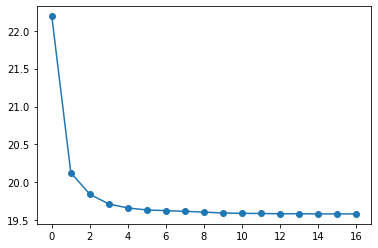

In [28]:
plt.plot(aics, marker='o')

In [29]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, May, 2021
Time:                     22:46:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    19.8493
Nobs:                     19733.0    HQIC:                   19.8436
Log likelihood:          -279739.    FPE:                4.13794e+08
AIC:                      19.8409    Det(Omega_mle):     4.13354e+08
--------------------------------------------------------------------
Results for equation x
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                16.627327         0.493965           33.661           0.000
L1.x                  0.422916         0.006628           63.808           0.000
L1.y                 -0.058780         0.007273           -8.082

In [31]:
from statsmodels.stats.stattools import durbin_watson
def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

x      : 2.16
y      : 2.16
Appliances : 1.98


In [32]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

2


array([[ 87.5       ,  21.65063509, 420.        ],
       [ 77.        ,  27.71281292, 430.        ]])

In [43]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=4934)
df_results = pd.DataFrame(fc, index=df.index[14801:], columns=df.columns)
df_results

,x,y,Appliances
14801,78.810496,25.700731,344.178181
14802,75.534402,27.782673,273.546033
14803,74.589925,28.006955,222.917443
14804,72.680034,29.115788,187.162255
14805,71.322443,29.798963,161.996460
...,...,...,...
19730,54.824348,40.646603,97.755511
19731,54.824348,40.646603,97.755511
19732,54.824348,40.646603,97.755511
19733,54.824348,40.646603,97.755511


KeyError: 'x_1d'

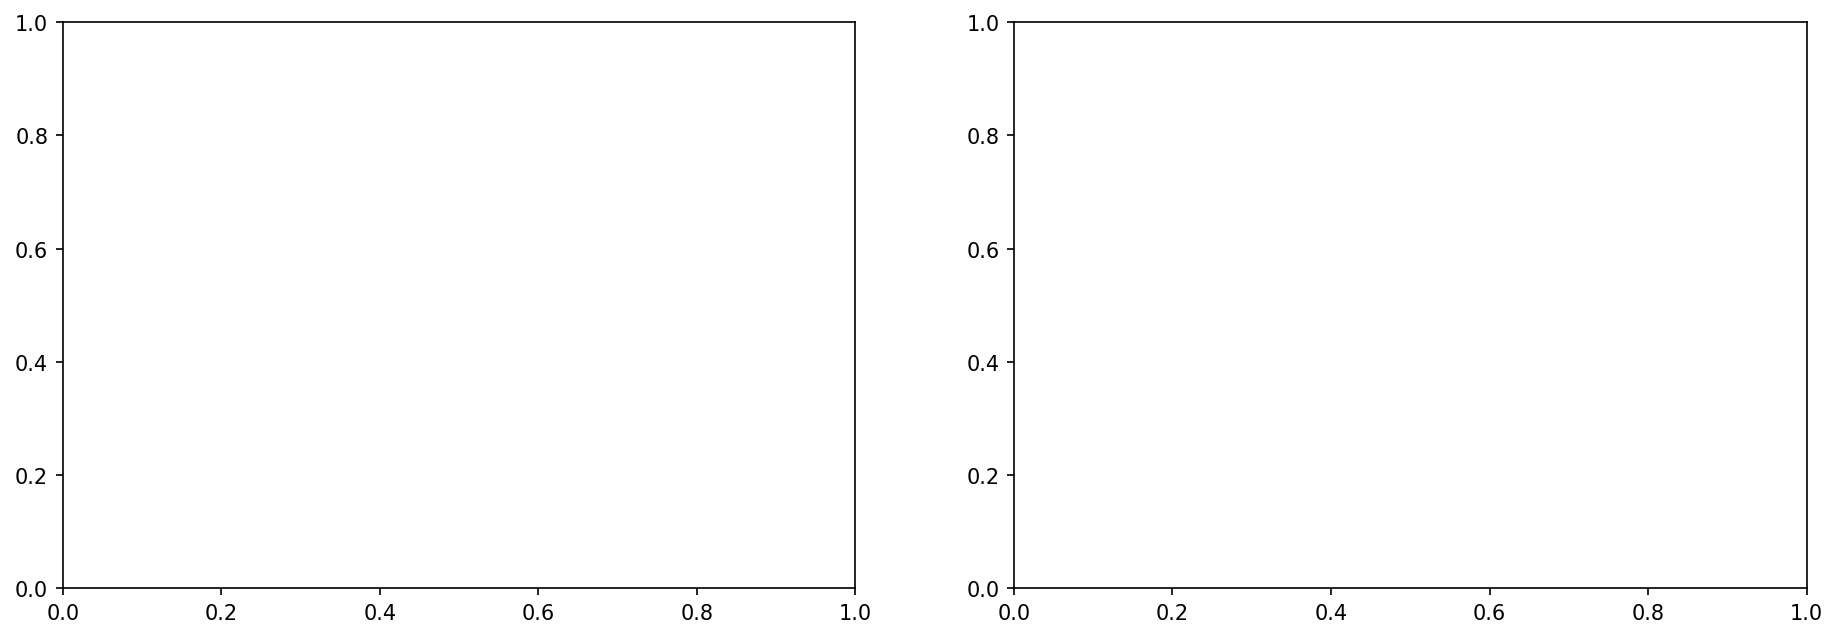

In [44]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(15,5))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_1d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [46]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Appliances')
accuracy_prod = forecast_accuracy(df_results['Appliances'].values, df_test['Appliances'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Appliances
mape   :  0.6063
me     :  3.56
mae    :  51.3338
mpe    :  0.4422
rmse   :  88.1965
corr   :  0.0599
minmax :  0.3626


<ipython-input-46-5884a93f4545>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-46-5884a93f4545>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
